# MPATE-GE 2623 - Music Information Retrieval
## Final Project


## Sound Classification for Instrument Recognition
---

In this final project, we will built on top of our HW1 Sound Classification for Instrument Recognition using MFCCs as the feature and explore a different approach using latent space as the feature.

Starting from an available dataset of samples from different instruments, we will extract timbre-related features from the audio. Once processed, the data will be segmented into training, validation, and testing sets to ensure the model's robustness and generalization capabilities.

Using a simple model, we will analyze and critic its performance, trying to explain its behaviour to be able to improve it in the future.

In [3]:
# This two lines of code make your notebook aware of changes in
# your utils.py file without needing to restart the session each time
%load_ext autoreload
%autoreload 2

In [3]:
# We will use mirdata to load and handle the data
# See https://mirdata.readthedocs.io/en/stable/source/overview.html
#!pip install mirdata # install mirdata

In [4]:
# This notebook is for visualization and written answers only
# Your code should go in utils.py
import utils as u # to use the functions from utils, do u.function()
import utils_latent as u_l

/Users/apple/anaconda3/envs/mirA2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Fix the random seed for reproducibility
from numpy.random import seed
seed(123)

## Part 1 - Load the data and split it





For this assignment we will use a subset of the Medley-Solos-DB dataset:

<blockquote>
V. Lostanlen, C.E. Cella. Deep convolutional networks on the pitch spiral for musical instrument recognition. Proceedings of the International Society for Music Information Retrieval Conference (ISMIR), 2016.
</blockquote>

This dataset is accessible to you for this homework in
[Google Drive](https://drive.google.com/file/d/1D8ji0ntQ2P72znec_7y9qdyNhXUtAslM/view?usp=sharing). To use it with this Colab notebook, you should download it and upload a copy on your Google Drive. You should create a `mir_datasets` folder and put the dataset there so it is accesible at `/content/drive/MyDrive/mir_datasets/medley_solos_db`.

### Part 1-A: Load the data using mirdata

In [9]:
# This snippet mounts your Drive so you can work with the dataset in it
#from google.colab import drive
#drive.mount('/content/drive/')

In [6]:
import mirdata

In [7]:
data_home = "/Users/apple/mir_datasets/medley_solos_db"
medley_large = mirdata.initialize('medley_solos_db')
# medley_large.download() 
#medley_large.validate()
dataset = u.load_data(data_home)
len(dataset.load_tracks())

21571

In [10]:
# using the complete large dataset instead of mini version, no longer need this cell
# import pandas as pd 
# metadata = pd.read_csv(data_home+'\\annotation\\Medley-solos-DB_metadata.csv')
# metadata_track_ids = metadata['uuid4'].values
# dataset.track_ids = metadata_track_ids
# print(len(dataset.load_tracks()))

In [16]:
# Check that the data loads correctly by loading a file
dataset.track('68d07e70-ce82-5800-f6e9-7619afaaacca').audio

(array([0.05877647, 0.07739695, 0.06003391, ..., 0.00279894, 0.00765386,
        0.01483029], dtype=float32),
 22050)

### Part 1-B: Divide the dataset into train, test, and validation splits.
### & Visualize the distribution of data




In [17]:
# run this to create the track lists
#print(dataset.load_tracks())
#print(dataset.load_tracks())
#print(dataset.track(1695065d-be3f-565b-f18b-28b394509e0c))
#for key, track in dataset.load_tracks().items():
#   print(key, track.subset)
    
tracks_train, tracks_validate, tracks_test = u.split_data(dataset.load_tracks())

print("There are {} tracks in the training set".format(len(tracks_train)))
print("There are {} tracks in the validation set".format(len(tracks_validate)))
print("There are {} tracks in the test set".format(len(tracks_test)))

There are 5841 tracks in the training set
There are 3494 tracks in the validation set
There are 12236 tracks in the test set


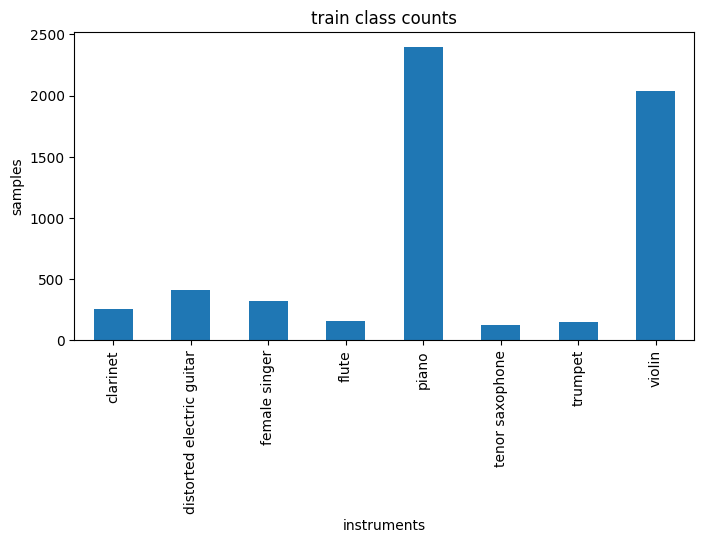

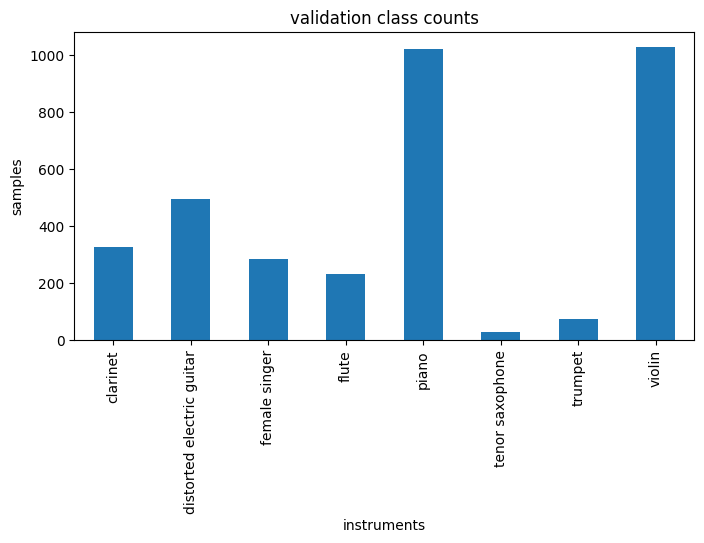

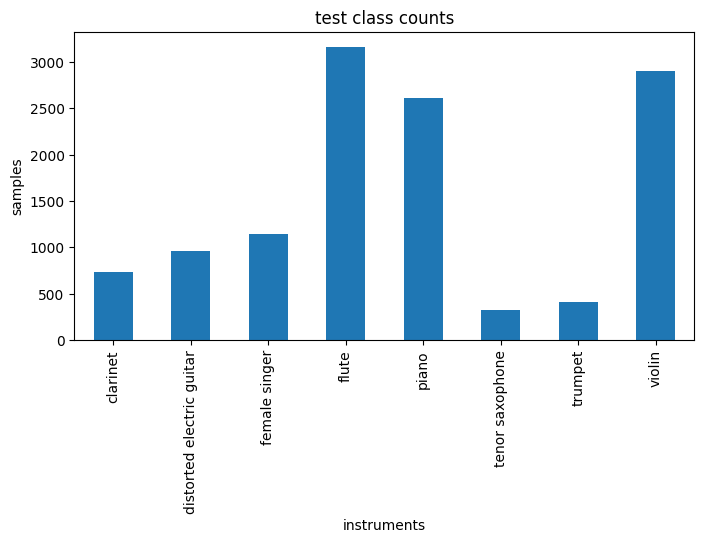

In [36]:
# visualize the data
import pandas as pd

data = pd.read_csv('/Users/apple/mir_datasets/medley_solos_db/annotation/Medley-solos-DB_metadata.csv')

# split the data into train, validation, and test using csv file
train_data = data[data['subset'] == 'training']
validation_data = data[data['subset'] == 'validation']
test_data = data[data['subset'] == 'test']

u.check_balance(train_data, 'train')
u.check_balance(validation_data, 'validation')
u.check_balance(test_data, 'test')

## Part 2: Extract Features


### Part 2-A: Compute the MFCCs of a track


In [18]:
track = dataset.track('68d07e70-ce82-5800-f6e9-7619afaaacca')
y_test, fs_test = track.audio

mfcc = u.compute_mfccs(y_test, fs_test)
print("{} time frames, {} mfcc coefficients".format(mfcc.shape[0], mfcc.shape[1]))


129 time frames, 19 mfcc coefficients


### Part 2-A: Compute the latent space of a track, using music2latent

In [ ]:
# uncomment to install music2latent， see repo: https://github.com/SonyCSLParis/music2latent
# !pip install music2latent

In [19]:
#testing for encoding and decoding function for audio
from music2latent import EncoderDecoder

encdec = EncoderDecoder()


latent = encdec.encode(y_test)
wv_rec = encdec.decode(latent)

import IPython
print('Original')
IPython.display.display(IPython.display.Audio(y_test, rate=fs_test))
print('Reconstructed')
IPython.display.display(IPython.display.Audio(wv_rec.squeeze().cpu().numpy(), rate=fs_test))


/Users/apple/anaconda3/envs/mirA2/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Original


Reconstructed


In [20]:
print(fs_test)

22050


In [21]:
# extract latent space feature for downstrem tasks or for our classification task, 64 channels are a highly-compressed form
features = encdec.encode(y_test)
# alternatively, can use extract_features = true, which will return a tensor with much higher number of channels
# features = encdec.encode(y_test, extract_features=True)
# "torch.Size([1, 8192, 15])


In [22]:
# print(features)
# print(features.shape)
print(features.size())

torch.Size([1, 64, 15])


### Part 2-B: Compute summary statistics




In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

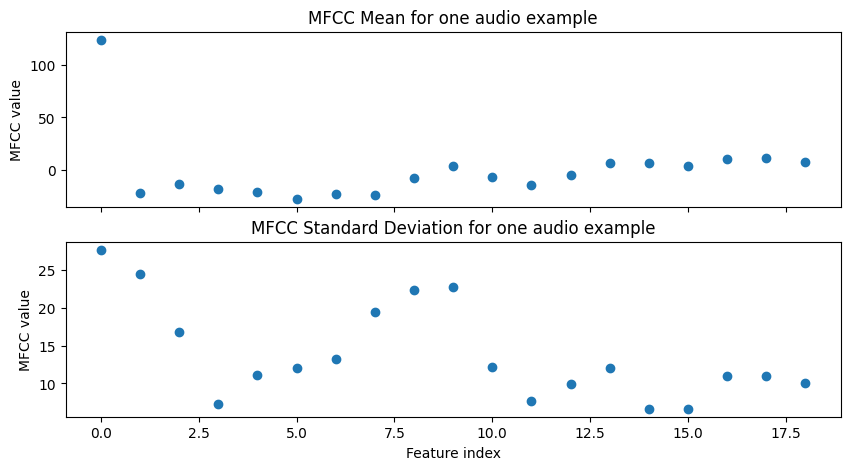

In [24]:
# test your function by running this code
mean, std = u.get_stats(mfcc)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex=True)
ax1.plot(np.arange(len(mean)), mean, 'o')
ax1.set_title("MFCC Mean for one audio example")
ax1.set_ylabel("MFCC value")
ax2.plot(np.arange(len(std)), std, 'o')
ax2.set_title("MFCC Standard Deviation for one audio example")
ax2.set_xlabel("Feature index")
ax2.set_ylabel("MFCC value")

plt.show()

## Part 3: Prepare the Data


### Part 3-A: Compute features for all data and reshape





In [21]:
# run this to obtain features and labels for each data split
# this can take some time.
X_raw_train, Y_train = u.get_features_and_labels(tracks_train)
X_raw_validate, Y_validate = u.get_features_and_labels(tracks_validate)
X_raw_test, Y_test = u.get_features_and_labels(tracks_test)

# save features so you don't have to run this again
np.save('X_raw_train.npy', X_raw_train)
np.save('X_raw_validate.npy', X_raw_validate)
np.save('X_raw_test.npy', X_raw_test)

np.save('Y_train.npy', Y_train)
np.save('Y_validate.npy', Y_validate)
np.save('Y_test.npy', Y_test)

In [ ]:
X_latent_train, Y_latent_train = u_l.get_features_and_labels_latent(tracks_train)
X_latent_validate, Y_latent_validate = u_l.get_features_and_labels_latent(tracks_validate)
X_latent_test, Y_latent_test = u_l.get_features_and_labels_latent(tracks_test)

np.save('X_latent_train.npy', X_latent_train)
np.save('X_latent_validate.npy', X_latent_validate)
np.save('X_latent_test.npy', X_latent_test)

np.save('Y_latent_train.npy', Y_latent_train)
np.save('Y_latent_validate.npy', Y_latent_validate)
np.save('Y_latent_test.npy', Y_latent_test)


### Part 3-B: Normalize the Data



In [10]:
# Load extracted features here. You don't need to train the model again!

# load raw data
X_raw_train = np.load('X_raw_train.npy')
Y_train = np.load('Y_train.npy')

X_raw_validate = np.load('X_raw_validate.npy')
Y_validate = np.load('Y_validate.npy')

X_raw_test = np.load('X_raw_test.npy')
Y_test = np.load('Y_test.npy')

# load latent data
X_latent_train = np.load('X_latent_train.npy')
Y_latent_train = np.load('Y_latent_train.npy')

X_latent_validate = np.load('X_latent_validate.npy')
Y_latent_validate = np.load('Y_latent_validate.npy')

X_latent_test = np.load('X_latent_test.npy')
Y_latent_test = np.load('Y_latent_test.npy')

In [11]:
# We normalize all features with the stats of the training data for assessing generalization

# Load here the data if you saved the features!
# ....

mu, sigma = u.get_stats(X_raw_train)

X_train = u.normalize(X_raw_train, mu, sigma)
X_validate = u.normalize(X_raw_validate, mu, sigma)
X_test = u.normalize(X_raw_test, mu, sigma)

In [12]:
mu, sigma = u.get_stats(X_latent_train)
X_latent_train = u.normalize(X_latent_train, mu, sigma)
X_latent_validate = u.normalize(X_latent_validate, mu, sigma)
X_latent_test = u.normalize(X_latent_test, mu, sigma)

## Part 4: Training and validation

### Method 1: KNN

/Users/apple/anaconda3/envs/mirA2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/apple/anaconda3/envs/mirA2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

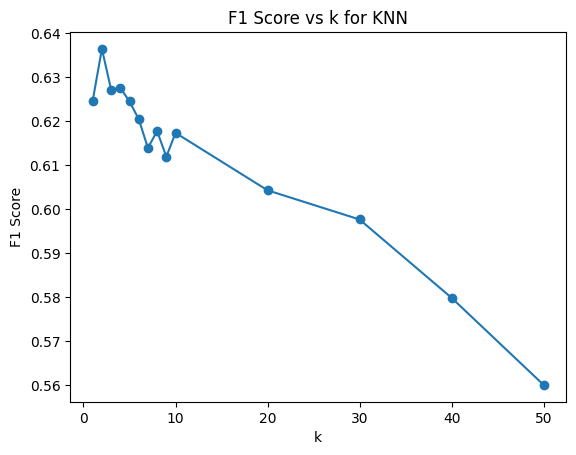

2


In [19]:
# run this to train the models
knn_clf, best_k = u.fit_knn(X_raw_train, Y_train, X_raw_validate, Y_validate)
print(best_k)

/Users/apple/anaconda3/envs/mirA2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/apple/anaconda3/envs/mirA2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

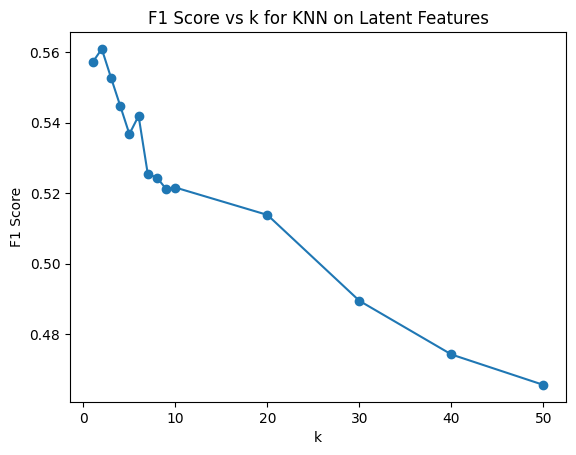

Best k: 2


In [23]:
knn_clf_latent, best_k_latent = u_l.fit_knn_latent(X_latent_train, Y_latent_train, X_latent_validate, Y_latent_validate)
print("Best k:", best_k_latent)

### Method 2: Random Forest

In [13]:
best_RF = u.fit_random_forest(X_raw_train, Y_train, X_raw_validate, Y_validate)
best_RF_latent = u.fit_random_forest(X_latent_train, Y_latent_train, X_latent_validate, Y_latent_validate)

best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### Method 3: Neural Network

In [14]:
best_NN = u.best_NN(X_raw_train, Y_train, X_raw_validate, Y_validate)
best_NN_latent = u.best_NN(X_latent_train, Y_latent_train, X_latent_validate, Y_latent_validate)

2024-12-06 16:44:33.889776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 16:44:33.889760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 16:44:33.889755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

the best paprameters are: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 30, 'hidden_layer_1': 32, 'hidden_layer_2': 32, 'optimizer': 'adam'}
the best paprameters are: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'hidden_layer_1': 64, 'hidden_layer_2': 16, 'optimizer': 'adam'}


### Method 4: SVM

In [15]:
best_SVM = u.best_SVM(X_raw_train, Y_train, X_raw_validate, Y_validate)
best_SVM_latent = u.best_SVM(X_latent_train, Y_latent_train, X_latent_validate, Y_latent_validate)

the best paprameters are: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
the best paprameters are: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## Part 5: Analysis

In [16]:
from sklearn.metrics import f1_score

### Part 5-A: Compute predictions and evaluate


1. Predict the labels for the test set.
2. Compute & print the average f1_score (or f_measure) in the dataset.

Hint: Look at the documentation of Sklearn on how to do the predictions, evaluation, etc.

In [21]:
y_pred_KNN = knn_clf.predict(X_raw_test)
y_pred_RF = best_RF.predict(X_raw_test)
y_pred_NN = best_NN.predict(X_raw_test)
y_pred_SVM = best_SVM.predict(X_raw_test)

# Step 2: Compute the average F1 score
f1_KNN = f1_score(Y_test, y_pred_KNN, average='macro')
f1_RF = f1_score(Y_test, y_pred_RF, average='macro')
f1_NN = f1_score(Y_test, y_pred_NN, average='macro')
f1_SVM = f1_score(Y_test, y_pred_SVM, average='macro')

# Print the F1 score
print("average score of KNN: " + str(f1_KNN))
print("average score of random forest: " + str(f1_RF))
print("average score of neural network: " + str(f1_NN))
print("average score of SVM: " + str(f1_SVM))

/Users/apple/anaconda3/envs/mirA2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


average score of KNN: 0.5634211014059952
average score of random forest: 0.6172533993960092
average score of neural network: 0.6056703781560921
average score of SVM: 0.6617780015488621


In [24]:
# YOUR CODE HERE
print(X_latent_test)
print(X_latent_test.shape)
y_latent_pred_KNN = knn_clf_latent.predict(X_latent_test)
y_latent_pred_RF = best_RF_latent.predict(X_latent_test)
y_latent_pred_NN = best_NN_latent.predict(X_latent_test)
y_latent_pred_SVM = best_SVM_latent.predict(X_latent_test)

# Step 2: Compute the average F1 score
f1_KNN = f1_score(Y_latent_test, y_latent_pred_KNN, average='macro')
f1_RF = f1_score(Y_latent_test, y_latent_pred_RF, average='macro')
f1_NN = f1_score(Y_latent_test, y_latent_pred_NN, average='macro')
f1_SVM = f1_score(Y_latent_test, y_latent_pred_SVM, average='macro')

# Print the F1 score
print("average score of KNN: " + str(f1_KNN))
print("average score of random forest: " + str(f1_RF))
print("average score of neural network: " + str(f1_NN))
print("average score of SVM: " + str(f1_SVM))

[[-0.3154  1.155  -0.563  ...  1.746   1.047   1.055 ]
 [-0.1815  1.499  -1.362  ...  0.922   1.118   1.902 ]
 [ 0.9478  1.543  -0.795  ...  0.5376  0.3848  2.133 ]
 ...
 [-2.225  -0.3713  0.7627 ... -0.0863  0.403  -0.1624]
 [-2.582  -0.932   0.9766 ...  0.5586  1.893  -0.916 ]
 [-1.956  -1.353  -0.605  ... -1.221  -0.4104 -0.9966]]
(12236, 128)


/Users/apple/anaconda3/envs/mirA2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


average score of KNN: 0.4788141014647972
average score of random forest: 0.4348644780440423
average score of neural network: 0.5727782740450491
average score of SVM: 0.6735769045932213


`# YOUR RESPONSE HERE`

### Part 5-B: Compute a confusion matrix
1. Compute the confusion matrix (use `sklearn.metrics.confusion_matrix`)
2. Plot the confusion matrix (see the example [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)).


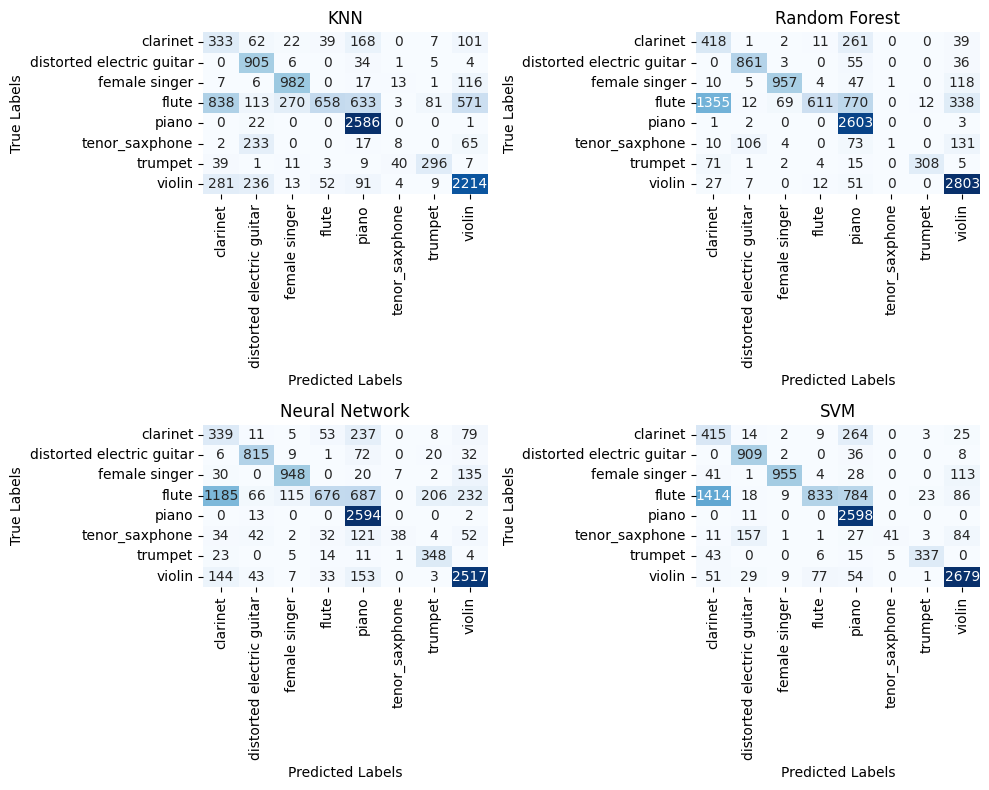

In [ ]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

matrix_KNN = confusion_matrix(Y_test, y_pred_KNN)
matrix_RF = confusion_matrix(Y_test, y_pred_RF)
matrix_NN = confusion_matrix(Y_test, y_pred_NN)
matrix_SVM = confusion_matrix(Y_test, y_pred_SVM)

# for print out classes instead of 0-7 labels
class_names = ['clarinet', 'distorted electric guitar', 'female singer', 'flute', 'piano', 'tenor_saxphone', 'trumpet', 'violin'] 

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
title = ['KNN', 'Random Forest', 'Neural Network', 'SVM']
matrix = [matrix_KNN, matrix_RF, matrix_NN, matrix_SVM]

for i, ax in enumerate(axs.flatten()):
    sns.heatmap(matrix[i], annot=True, fmt='d', cmap='Blues', cbar=False,  xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(title[i])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

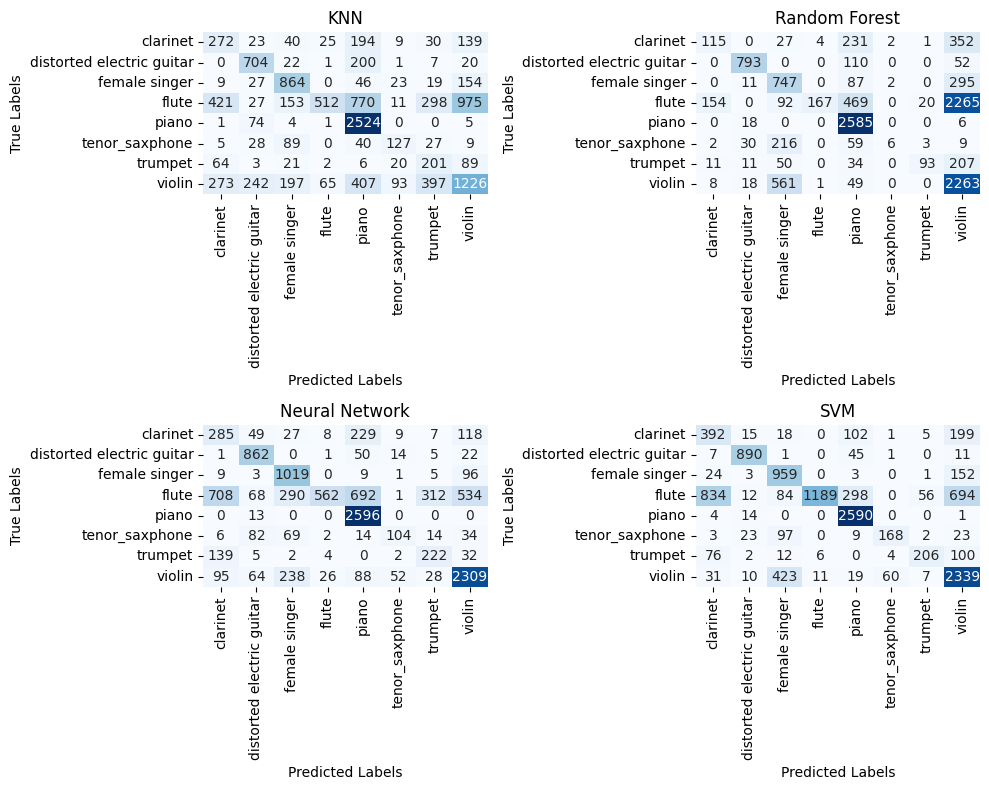

In [32]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

matrix_latent_KNN = confusion_matrix(Y_latent_test, y_latent_pred_KNN)
matrix_latent_RF = confusion_matrix(Y_latent_test, y_latent_pred_RF)
matrix_latent_NN = confusion_matrix(Y_latent_test, y_latent_pred_NN)
matrix_latent_SVM = confusion_matrix(Y_latent_test, y_latent_pred_SVM)

# for print out classes instead of 0-7 labels
class_names = ['clarinet', 'distorted electric guitar', 'female singer', 'flute', 'piano', 'tenor_saxphone', 'trumpet', 'violin'] 

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
title = ['KNN', 'Random Forest', 'Neural Network', 'SVM']
matrix = [matrix_latent_KNN, matrix_latent_RF, matrix_latent_NN, matrix_latent_SVM]

for i, ax in enumerate(axs.flatten()):
    sns.heatmap(matrix[i], annot=True, fmt='d', cmap='Blues', cbar=False,  xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(title[i])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

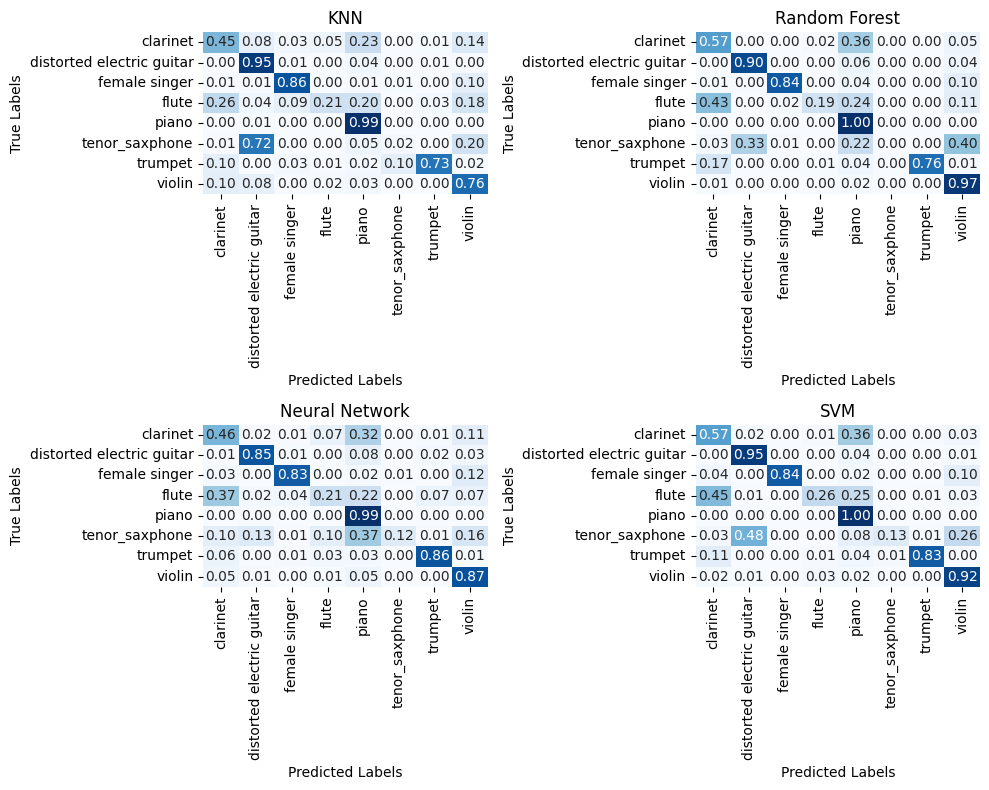

In [34]:
# for printing a normalized matrix
matrix_norm_KNN = confusion_matrix(Y_test, y_pred_KNN, normalize='true' )
matrix_norm_RF = confusion_matrix(Y_test, y_pred_RF, normalize='true' )
matrix_norm_NN = confusion_matrix(Y_test, y_pred_NN, normalize='true' )
matrix_norm_SVM = confusion_matrix(Y_test, y_pred_SVM, normalize='true' )

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
title = ['KNN', 'Random Forest', 'Neural Network', 'SVM']
matrix = [matrix_norm_KNN, matrix_norm_RF, matrix_norm_NN, matrix_norm_SVM]

for i, ax in enumerate(axs.flatten()):
    sns.heatmap(matrix[i], annot=True, fmt='.2f', cmap='Blues', cbar=False,  xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(title[i])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

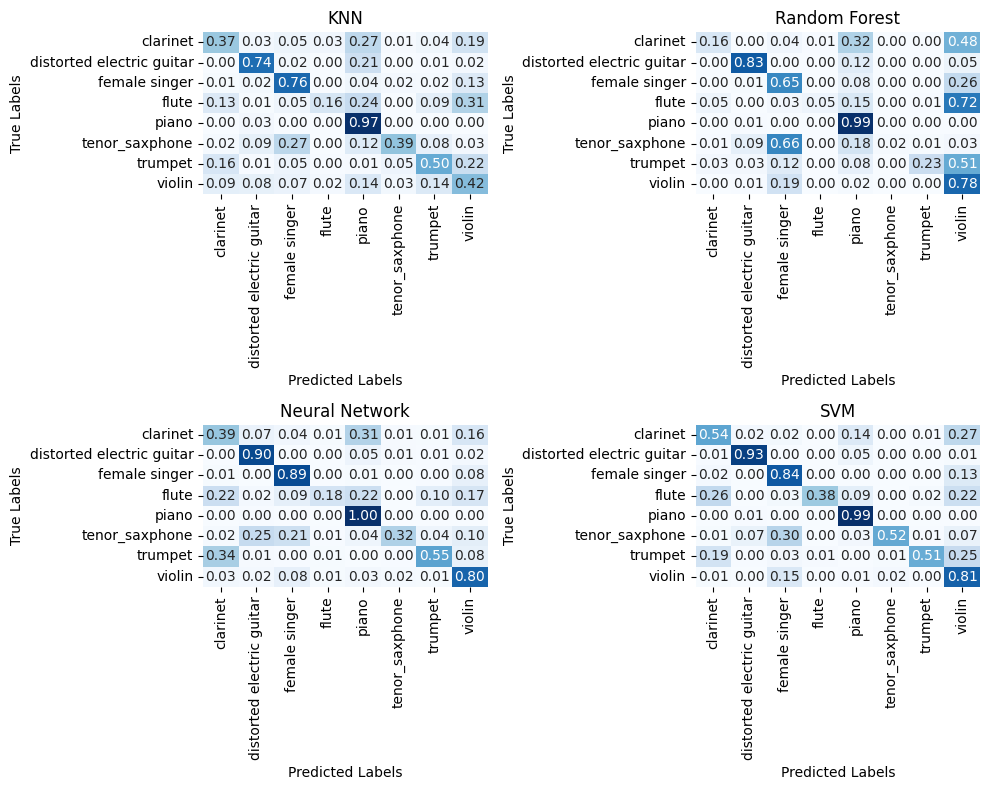

In [ ]:
# for printing a normalized matrix for latent data
matrix_norm_latent_KNN = confusion_matrix(Y_latent_test, y_latent_pred_KNN, normalize='true' )
matrix_norm_latent_RF = confusion_matrix(Y_latent_test, y_latent_pred_RF, normalize='true' )
matrix_norm_latent_NN = confusion_matrix(Y_latent_test, y_latent_pred_NN, normalize='true' )
matrix_norm_latent_SVM = confusion_matrix(Y_latent_test, y_latent_pred_SVM, normalize='true' )

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
title = ['KNN', 'Random Forest', 'Neural Network', 'SVM']
matrix = [matrix_norm_latent_KNN, matrix_norm_latent_RF, matrix_norm_latent_NN, matrix_norm_latent_SVM]

for i, ax in enumerate(axs.flatten()):
    sns.heatmap(matrix[i], annot=True, fmt='.2f', cmap='Blues', cbar=False,  xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(title[i])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()
